CSE2525 Data Mining Lab Assignment 1

Ágoston Szabó, Arnon Zandt


In [1]:
import scipy as sci
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_file_path = 'lab1_train.csv'
train_data = pd.read_csv(train_file_path, delimiter=',')
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

test_file_path = 'lab1_test.csv'
test_data = pd.read_csv(test_file_path, delimiter=',')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

In [3]:
def visualize_sensor_data(df, window=None, sensors=None, title='Sensor Data Visualization'):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title(title)
    plt.legend()
    plt.show()

Familiarization (10 points) 
 
Load the sensor data (train with training data, test with test data) into a Jupyter 
Notebook and understand the data using visualizations. Answer the following questions:  
1. What types of signals are there? 
2. Are the signals correlated? Do they show cyclic behavior? 

Visualize these types and the presence or absence of correlation. 

The graphs below show the sensors categorized by certain properties.
1. The sensors vary in behavior but can be categorized in a couple ways. Some sensors follow a cyclical pattern and some do not. The sensors also differ in that they are discrete or continuous. Both the discrete and continuous sensors have sensors that are cyclical and sensors that are not cyclical.

2. Generally sensors with the same prefix follow similar behavior and thus correlate the most, but there are exceptions. Sensors with the 'P' prefix are discrete and sensors with the 'LIT' prefix are cyclical, continuous, and are highly volatile in a wide range of values. An exception would be sensors in the "AIT" group have values in vastly different ranges, although the shape of the graph is similar. "AIT503" follows a cyclical pattern as opposed to the other sensors in the "AIT" group. Only sensor 'P603' has the value 1 for every data point in this particular dataset. Sensor "AIT504" starts with a large spike, but after that only has a low range of values.

C:\Users\Arnon\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


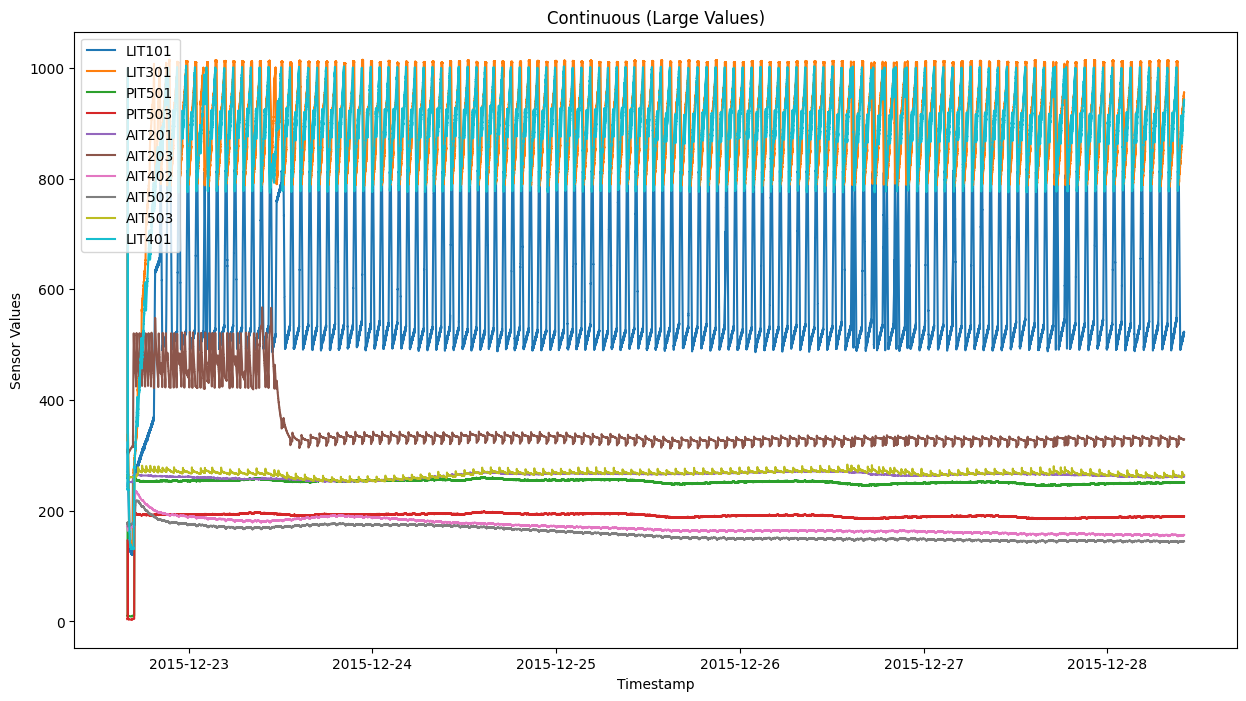

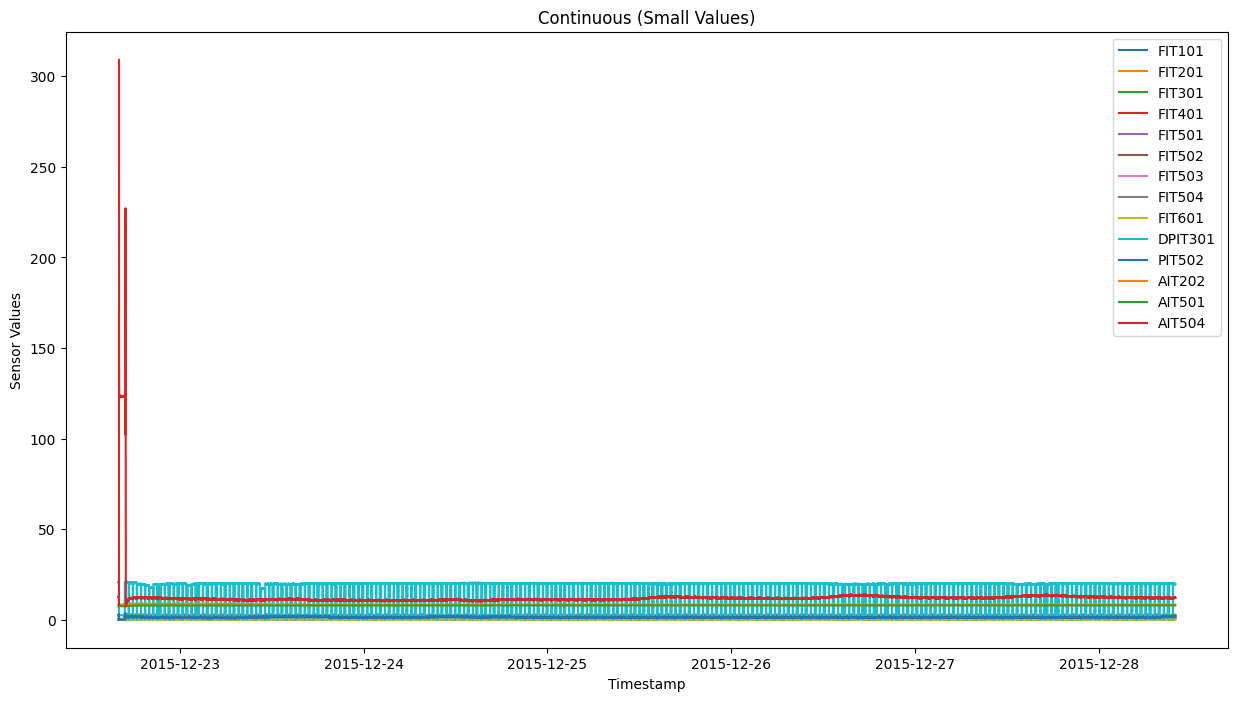

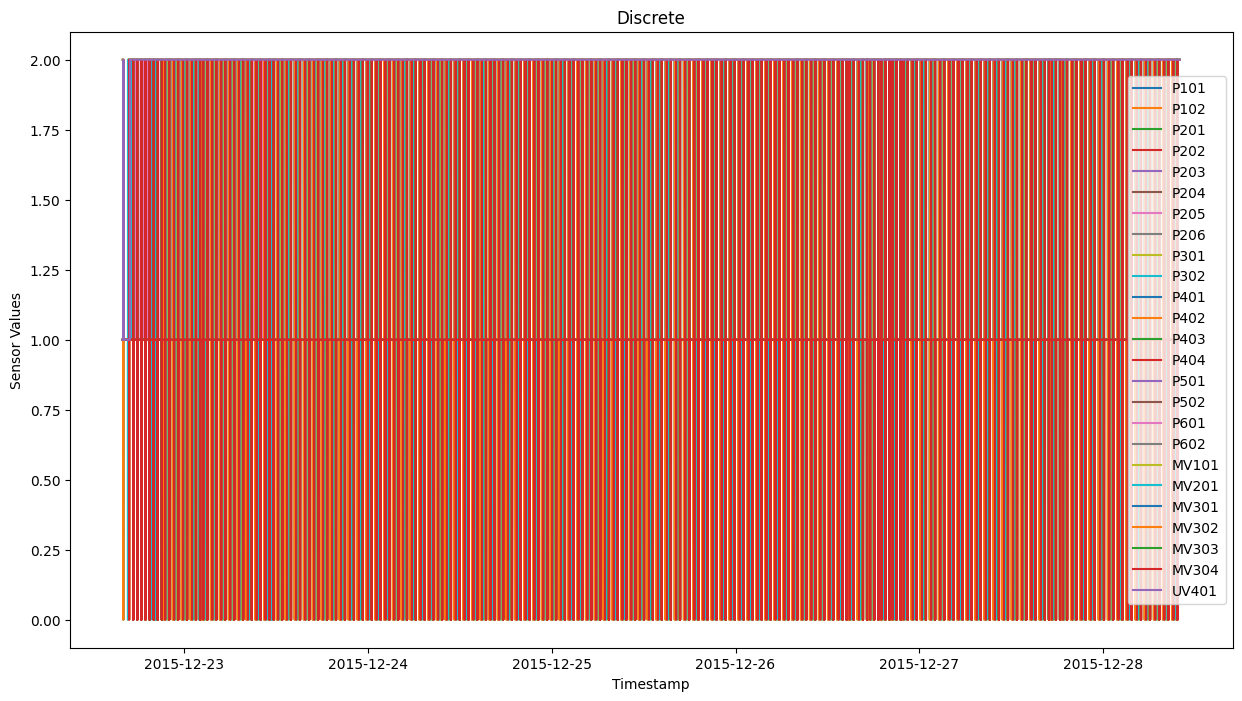

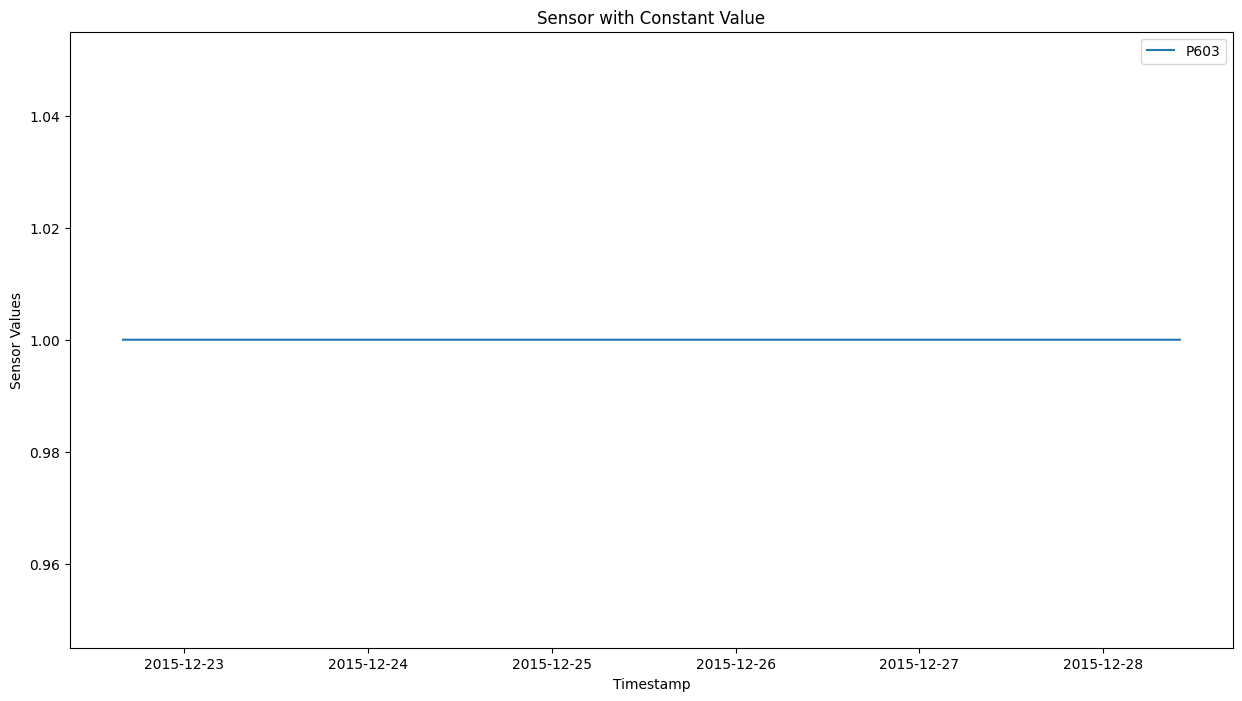

In [4]:
#Continuous (Large)
visualize_sensor_data(train_data, sensors=['LIT101', 'LIT301', 'PIT501', 'PIT503', 'AIT201', 'AIT203', 'AIT402', 'AIT502', 'AIT503', 'LIT401'],
                        title="Continuous (Large Values)")

#Continuous (Small)
visualize_sensor_data(train_data, sensors=['FIT101', 'FIT201', 'FIT301', 'FIT401', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'FIT601', 'DPIT301', 'PIT502', 'AIT202', 'AIT501', 'AIT504'],
                        title="Continuous (Small Values)")

#Discrete
visualize_sensor_data(train_data, sensors=['P101', 'P102', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206', 'P301', 'P302', 'P401', 'P402', 'P403', 'P404', 'P501', 'P502', 'P601', 'P602',
                        'MV101', 'MV201', 'MV301', 'MV302', 'MV303', 'MV304', 'UV401'],
                        title="Discrete")

#Constant
visualize_sensor_data(train_data, sensors=['P603'], title="Sensor with Constant Value")

DTW-based anomaly detection – (15 points)  
 
Choose one signal that displays interesting temporal behavior. Build a set of 
representative sliding windows from the training data. This can be all data points, but to 
lower the run-time you can consider taking a subset. Plot the distances (sometimes 
called residual) of the train and test data points of this signal to their closest 
representative window (excluding overlapping ones). What kind of anomalies do you 
expect to detect using DTW distances in this manner?  
 
Experiment with using different sliding window sizes and jumps (sometimes called 
stride). Set these in such a way that you expect to detect anomalies with a low number of 
false alarms and such that the run-time is not too large. Show your analysis and explain 
your expectation. 

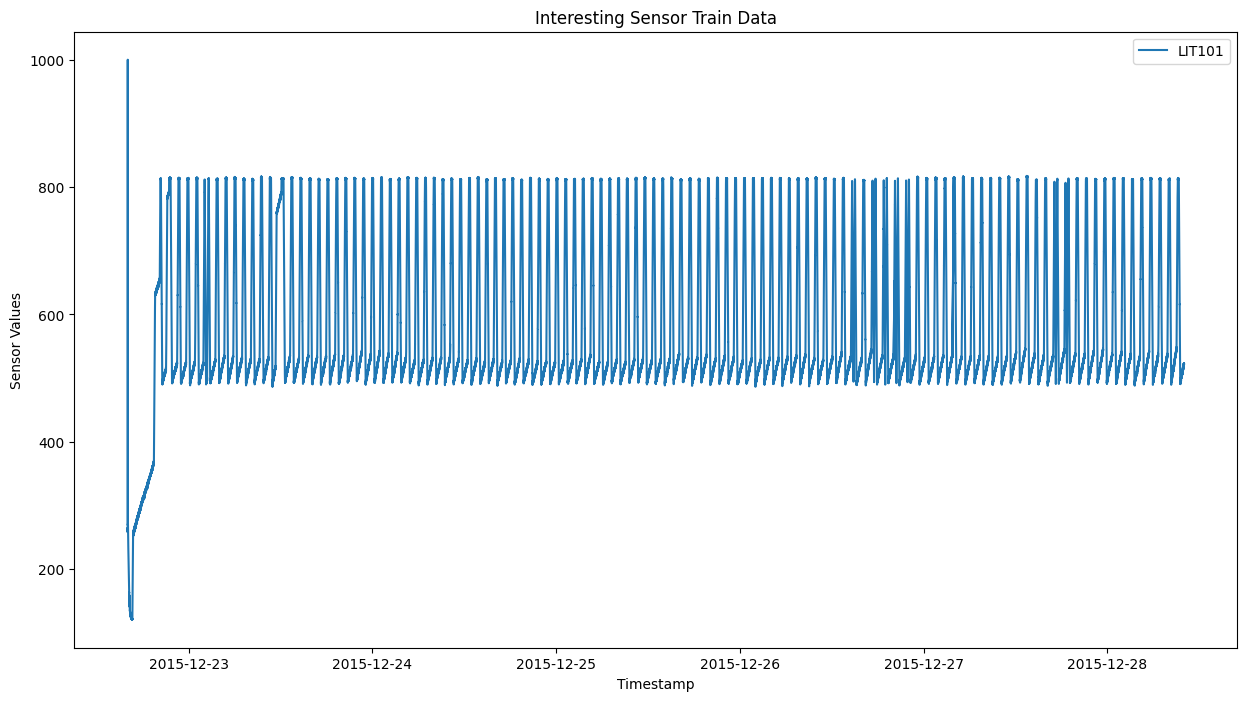

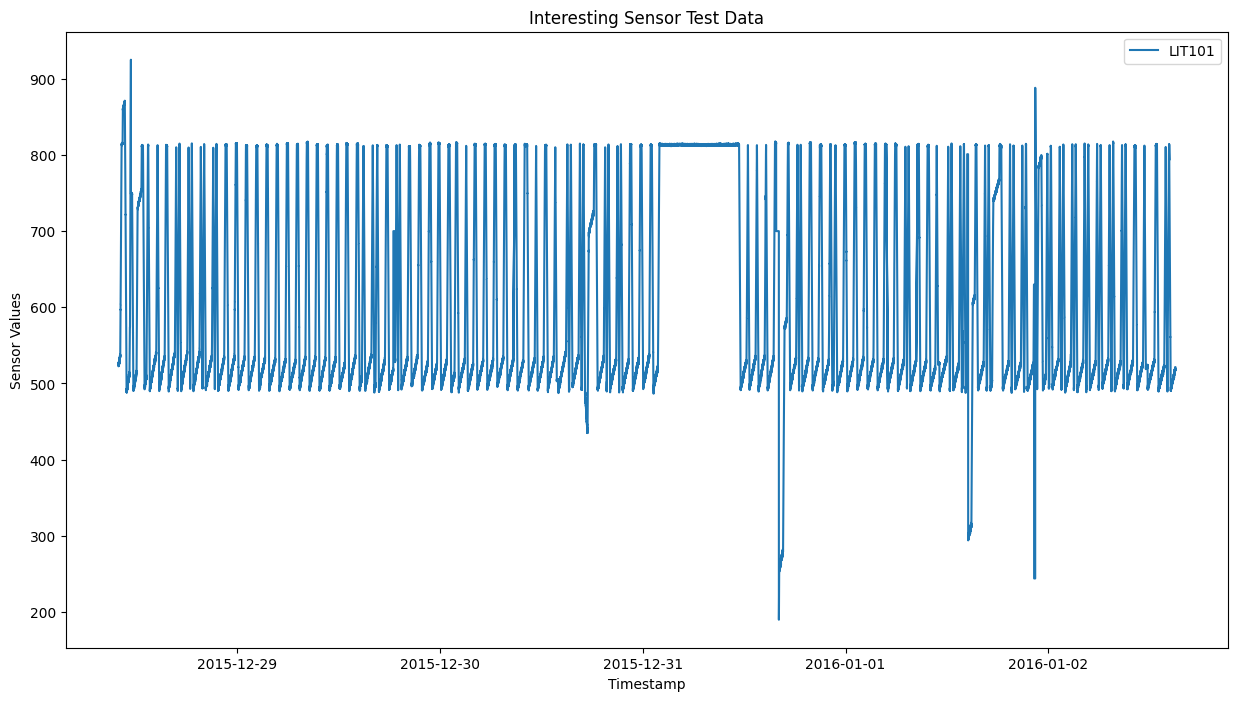

In [5]:
# here we take a look at an interesting signal
signal = "LIT101"
visualize_sensor_data(train_data, sensors=[signal],title="Interesting Sensor Train Data")
visualize_sensor_data(test_data, sensors=[signal],title="Interesting Sensor Test Data")

The signal clearly has anomalies. We try to detect them by normalizing, sampling the data and building windows out of them. Then we compare DTW distances between windows from test data, and representative windows built from training data.

In [6]:
def normalize_data(sig):
    mean = sig.mean()
    sd = sig.std()
    return sig.apply(lambda x: (x-mean)/sd)

In [7]:
# Creates sliding windows from an array with a given size and jump
def build_windows(data, windowSize, jump):
    amountOfWindows = np.floor((len(data)-windowSize) / jump) + 1
    windows = np.zeros(shape=(int(amountOfWindows),windowSize))
    # print("amount of windows, windowSize and jump:", int(amountOfWindows), ", ", windowSize, ", ", jump)
    for i in range(int(amountOfWindows)):
        for j in range(windowSize):
            # print("Window index:", i, ",", j)
            # print("Data Index:", j + i * jump)
            windows[i,j] = data[j + i * jump]
    return windows

In [8]:
# Calculates DTW distance between two time series.
# Model contains the data of a representative window, test contains the data of a window. W is the size of the gap, lower values are less accurate, but compute faster.
# Compute Time scales with n*m
def get_dtw_distance(model, test, w):
    n = len(model)
    m = len(test)
    w = max(w, abs(n-m)) # make sure window size is not too large
    DTW = np.matrix(np.ones((n,m)) * np.inf)
    DTW[0, 0] = 0
    # print("i in range", 1,n)
    for i in range(1,n):
        # print("i in range", max(1,i-w),min(m, i+w))
        for j in range(max(1,i-w),min(m, i+w)):
            cost = (model[i] - test[j]) ** 2
            DTW[i, j] = cost + np.min([DTW[i-1, j], DTW[i,j-1], DTW[i-1, j-1]])
    # print(DTW)
    return np.sqrt(DTW[n-1, m-1])

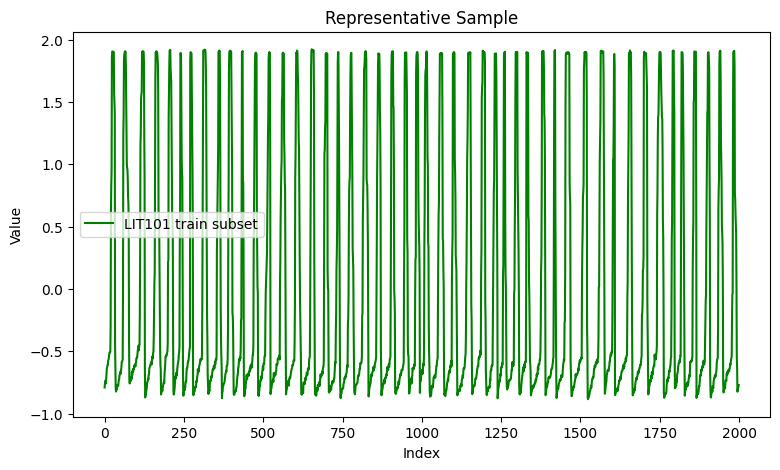

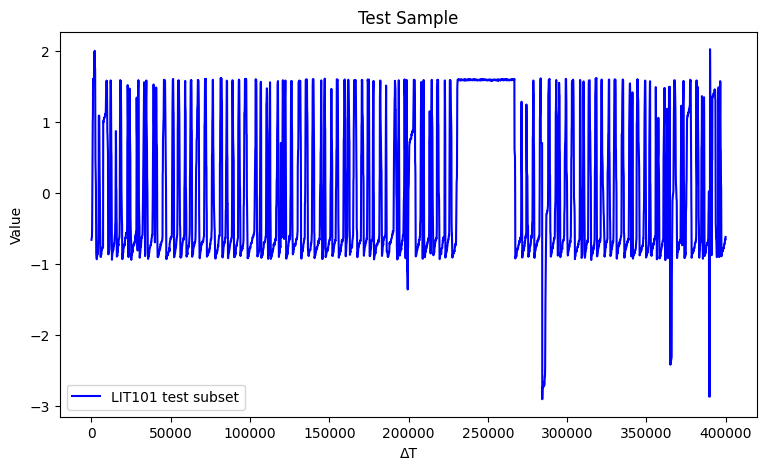

train_density/test_density 1.0


In [9]:
# Graph of subset to build train and test windows on. Windows are built on normalized, then sampled data
# We try to choose the values such that, the train indexes represent a fair subset of the dataset for representative windows.
# The sample size is small enough to decrease runtime, but large enough to still have an accurate shape. 
# For train and test to be equally "dense" with data points, we simply have that the proportion between length of data set and sample size is the same.
# i.d. (representative_end - representative_start) / representative_sample = (test_end - test_start) / test_sample
representative_start = 100000
representative_end = 300000
representative_sample = 2000

test_start = 0
test_end = 400000
test_sample = 4000

sample_representative_data = normalize_data(train_data[signal][representative_start:representative_end]).sample(representative_sample).sort_index().tolist()
sample_test_data = normalize_data(test_data[signal][test_start:test_end]).sample(test_sample).sort_index().tolist()

plt.figure(figsize=(9, 5))
plt.plot(range(len(sample_representative_data)), sample_representative_data, c='g', label=signal + " train subset")
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("Representative Sample")
plt.legend()
plt.show()

#Scale x_axis
test_x_values = np.arange(len(sample_test_data)) * (test_end-test_start) / len(sample_test_data)

plt.figure(figsize=(9, 5))
plt.plot(test_x_values, sample_test_data, c='b', label=signal + " test subset")
plt.xlabel('ΔT')
plt.ylabel('Value')
plt.title("Test Sample")
plt.legend()
plt.show()

density_proportion = ((representative_end - representative_start) / representative_sample) / ((test_end - test_start) / test_sample)
print("train_density/test_density", density_proportion)

Our Representative sample is representative of what the shape of the graph is normally like. Our test sample clearly has anomalies.

In [10]:
# Build representative sliding windows with a given size and jump.
# We try to choose the values such that, the train indexes represent a fair subset of the dataset for representative windows.
# The sample size is small enough to decrease runtime, but large enough to still be accurate. 
# window sizes are chosen so they are roughly equal to two cycles

representative_window_size = 90
representative_window_jump = 300

test_window_size = 90
test_window_jump = 10

representative_windows = build_windows(sample_representative_data, representative_window_size, representative_window_jump)
test_windows = build_windows(sample_test_data, test_window_size, test_window_jump)

# Here we want to align the lengths of test and train data so they can be compared fairly (similar shape). 
# The time span of a window is (end_index - start_index) * window_size/sample_size. We use indexes because in the original data set each index is 1 second.
# We try to align the time spans of representative and test windows. i.e, representative_time_span/test_time_span = 1 (or close to 1)

representative_time_span = (representative_end - representative_start) * representative_window_size / representative_sample
test_time_span = (test_end - test_start) * test_window_size / test_sample 

print("representative_time_span/test_time_span:", representative_time_span/test_time_span)
print(len(representative_windows), "representative windows")
print(len(test_windows), "test windows")

# Calculate DTW distances between all test windows and all representative windows
def min_dtw_distances(repr, test, gap):
    gap = 20
    distances = np.zeros(shape=(len(repr), len(test)))
    for i in range(len(repr)):
        for j in range(len(test_windows)):
            distance = get_dtw_distance(repr[i], test[j], gap)
            distances[i,j] = distance

    # Find minimized distance for each test window with their representative window
    minDistances = np.ones(distances.shape[1]) * np.inf
    for i in range(distances.shape[0]):
        for j in range(distances.shape[1]):
            if minDistances[j] > distances[i,j]:
                minDistances[j] = distances[i,j]
    return minDistances

# We choose a value for gap such that run time is acceptable and DTW distances are still accurate
gap = 20
minDistances = min_dtw_distances(representative_windows, test_windows, gap)
mean = minDistances.mean()
std = minDistances.std()
print("mean", mean)
print("std", std)

representative_time_span/test_time_span: 1.0
7 representative windows
392 test windows
mean 4.66376423213357
std 4.119746856228318


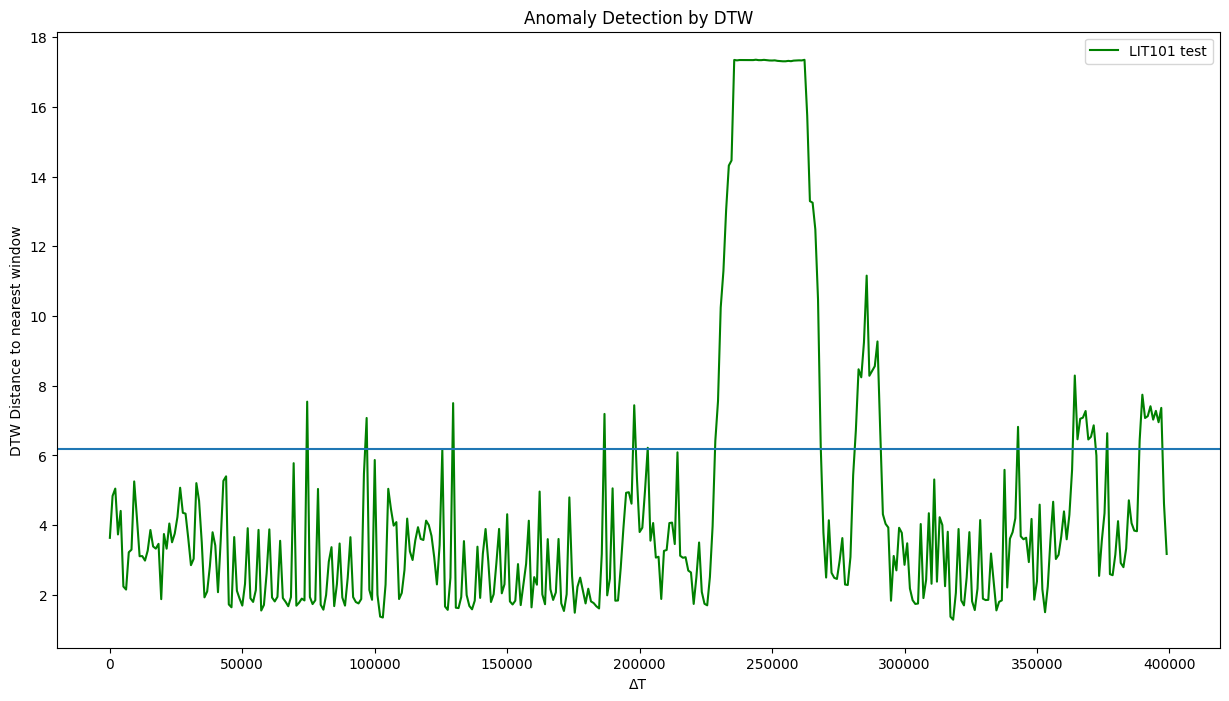

In [11]:
window_timestamp_proportion = (test_end-test_start) / minDistances.shape[0]
x_values = np.arange(minDistances.shape[0]) * window_timestamp_proportion
plt.figure(figsize=(15, 8))
plt.plot(x_values, minDistances, c='g', label=signal + " test")
plt.xlabel('ΔT')
plt.ylabel('DTW Distance to nearest window')
plt.title("Anomaly Detection by DTW")
plt.axhline(1.5*std)
plt.legend()
plt.show()

The sensor seemed to have failed around x=250000. This is clearly visible by looking at DTW distance. There are other peaks besides those which are either point anomalies or context anomalies. There is a line drawn at std*1.5. The constant 1.5 was arbitrarily chosen and is not necessarily optimal for classifying anomalies, but works for simple observation.

In [12]:
# Do same for train data
train_start = 0
train_end = 400000
train_sample = 4000
train_window_size = 90
train_window_jump = 10

sample_train_data = normalize_data(train_data[signal][train_start:train_end]).sample(train_sample).sort_index().tolist()

train_windows = build_windows(sample_train_data, train_window_size, train_window_jump)

gap = 20
minDistances = min_dtw_distances(representative_windows, train_windows, gap)
mean = minDistances.mean()
std = minDistances.std()
print("mean", mean)
print("std", std)

mean 2.851386104056769
std 2.617161030307724


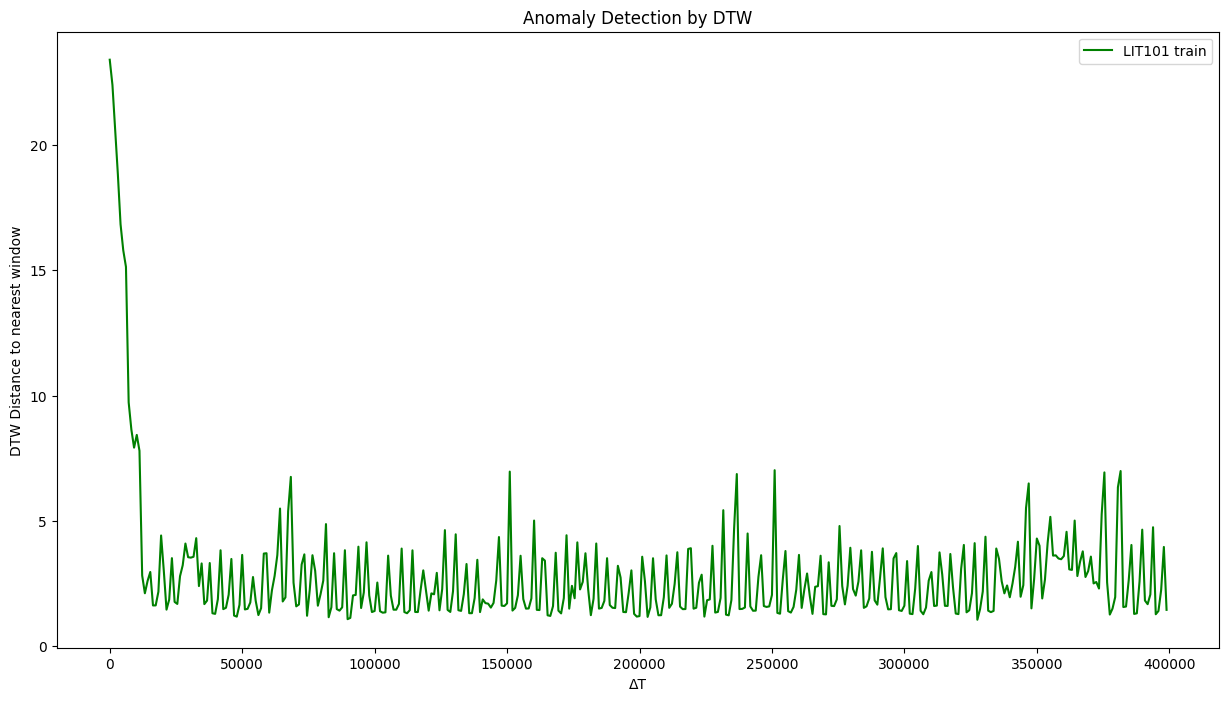

In [13]:
window_timestamp_proportion = (train_end-train_start) / minDistances.shape[0]
x_values = np.arange(minDistances.shape[0]) * window_timestamp_proportion
plt.figure(figsize=(15, 8))
plt.plot(x_values, minDistances, c='g', label=signal + " train")
plt.xlabel('ΔT')
plt.ylabel('DTW Distance to nearest window')
plt.title("Anomaly Detection by DTW")
plt.legend()
plt.show()

The train data clearly lacks the high peaks that the test data has (with exception of the start). This is expected.

PCA-based anomaly detection – (15 points)  
 
Perform PCA-based anomaly detection on the signal multivariate data points (do not 
take sequential context into account). You compute PCA to the train data, and apply it to 
both the train and test data. Plot the distance (residual, your choice of distance function) 
between the original and reconstructed data points. Do you see large abnormalities in 
the training data? Can you explain why these occur? It is best to remove such 
abnormalities from the training data since you only want to model normal behavior. 
Describe the kind of anomalies you expect to detect using PCA. 
 
Plot the PCA residuals for different number of components on the training data as one 
signal.  Choose the number of components based on the residuals and detected 
anomalies. Aim to set it such that you expect a small number of false alarms while still 
able to detect anomalies. Show your analysis and explain your expectation.